# Human-Level Control Through Deep Reinforcement Learning
* DQN
* nature 2015
* 구글 딥마인드 연구
* DQN 논문 리뷰 영상 https://www.youtube.com/watch?v=eJXQKEtPvhY 의 슬라이드 참고

## Objective
* input: 게임화면을 state로 주고, 게임 점수는 reward로 줌
* output: reward 기대값 최대가 되는 policy 찾기
* 구체적인 state를 주지않고, 게임 pixel만 줘서 사람보다 게임 잘하는 agent 를 만듦

## 1. 사전 지식

### Q-Learning
* TD target은 우리가 학습시키려는 policy $\pi$에서 greedy 하게 뽑고

$$
\pi (S_{t+1}) = \arg \max_{a'} Q(S_{t+1}, a')
$$

* 현재 value는 behaviour policy $\mu$ (이놈은 우리가 배우고자하는 policy. 예를 들어 사람의 행동일 수도 있고, 좀 더 성능이 나은 agent의 policy일 수도 있음) 에서 $\epsilon$-greedy 하게 뽑음

$$Q(S,A) \leftarrow Q(S,A) + \alpha \big( R + \gamma \max_{a'} Q(S',a') - Q(S,A) \big)$$

(Q-learning control은 최적 action-value function 으로 수렴한다는 것이 증명되어 있음)

### Value Function Approximation (by SGD)
* Goal: true value function $v_\pi (s)$ 가 있다고 할 때, 이걸 바로 구할 수 없으니깐 학습시킬 수 있는 parameter $\mathbf{w}$ 를 써서, value function $\hat{v}(s,\mathbf{w})$ 를 사용해서 true value function 에 근사시키자. 이 때 MSE 를 써서 근사시킨다.

$$
J(\mathbf{w}) = \mathbb{E}_\pi \big[ (v_\pi (S) - \hat{v}(S, \mathbf{w}))^2 \big]
$$

* GD로 local minimum 찾으려면

\begin{align}
\Delta \mathbf{w} & = - {1 \over 2} \alpha \nabla_w J(w)\\
& = \alpha \mathbb{E}_\pi [ (v_\pi (S) - \hat(v) (S, w))\nabla_w \hat{v} (S, w) ]
\end{align}

(위에 있는 J(w) 첫 행에 그대로 대입, 알파는 미분할 놈 아니라 앞으로 나오고, V(s)도 w없어서 사라지고 둘째 줄 처럼 미분 결과 나옴)

* 위 식에서 샘플링하면 expectation 사라짐 -> SGD

$$
\Delta w = \alpha (v_\pi (S) - \hat{v} (S, w)) \nabla_w \hat{v}(S,w)
$$

### Incremental Prediction Algorithms
* 위 w 업뎃 방법은 oracle만 아는 $v_\pi (s)$ 를 우리도 안다고 생각하고 업뎃해야하는데
* 현실 세계에서는 그걸 모름
* 그래서 걍 $v_\pi(s)$ 자리에 다가 관측한 리턴 $G_t$ 를 넣으면 됨. 즉,
  * MC 라면 target 은 return $G_t$
  
  $$
  \Delta w = \alpha (G_t - \hat{v} (S_t, w)) \nabla_w \hat{v}(S_t, w)
  $$
  
  * TD(0) 이라면 TD target $R_{t+1} + \gamma \hat{v} (S_{t+1}, w)$ 적용
  
  $$
  \Delta w = \alpha (R_{t+1} + \gamma \hat{v} (S_{t+1}, w) - \hat{v} (S_t, w))\nabla_w \hat{v} (S_t, w)
  $$
  
  * TD($\lambda$)는 $\lambda$-return $G_t^\lambda$ 대입하면 됨
  
  $$
  \Delta w = \alpha (G_t^\lambda - \hat{v}(S_t, w))\nabla_w \hat{v}(S_t,w)
  $$

## 2. 학습 방법
### Control
$$
L_i (\theta_i) = \mathbb{E}_{s,a,r,s'}\sim U(D) \Bigg[ \Bigg( r + \gamma \max_{a'} Q(s',a';\theta_i^-) - Q(s,a;\theta_i) \Bigg)^2 \Bigg]
$$

* Behaviour policy 는 학습할 수 있도록 맨날 켜두고
* Target policy 고정해두고 몇 iteration 마다 behaviour policy 복제해옴

* SGD 적용 하려면 위 control 식 미분

$$
\nabla_{\theta_i} L(\theta_i) = \mathbb{E}_{s,a,r,s'}\Bigg[ \Bigg( r + \gamma \max_{a'} Q(s',a';\theta_i^-) - Q(s,a;\theta_i) \Bigg) \nabla_{\theta_i}Q(s,a;\theta_i) \Bigg]
$$

* Q 함수는 CNN 모델로 function approximation 해버림

### 학습 안정성
* RL에서 비선형 함수를 사용하면 학습 불안정 (발산하기도 함)
* 왜냐면 observation 의 sequence에 있는 correlation 때문 (에피소드 끝날 때 까지 한 시쿼스 씩 가져다가 학습시키면 variance 커서 그런듯)
$\rightarrow$
* 해결법
  * experience replay
  * target network

#### Experience Replay
* 시뮬레이션 돌리며 매 틱(time step) 마다 생성되는 transition 튜플 $(s_t, a_t, r_t, s_{t+1})$을 replay buffer에 저장해둠
* replay buffer에서 uniform 하게 sampling 해서 minibatch 가져다가 학습시킴

#### Target Network
(위에 요 내용)
* Behaviour policy 는 학습할 수 있도록 맨날 켜두고
* Target policy 고정해두고 몇 iteration 마다 behaviour policy 복제해옴

### Pseudo Code
(원래 이미지 전처리하는 과정도 있어야하지만 그건 빼고 적음)
* Replay memory D와 총 개수 N을 초기화 함
* action-value function Q를 초기화 함 (뉴럴넷의 weight $\theta$를 초기화)
* target action-value function $\hat{Q}$의 weight 초기화 $\theta^- = \theta$

**For episode = 1, M do**<br>
&nbsp;&nbsp;&nbsp;&nbsp;시퀀스 $s_1 = \{ x_1 \}$와 preprocessed sequence $\phi_1 = \phi (s_1)$(이미지 처리용)을 초기화<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**For t=1, T do**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\epsilon$-greedy 로 action $a_t$ 선택<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;시뮬 돌려서 state $s_{t+1}$ 이랑 reward $r_t$ 얻음<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s_{t+1} = s_t, a_t$ 얻음<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;transition $s_t, a_t, r_t, s_{t+1}$ 을 D에 넣음<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;D로부터 미니배치 샘플링함<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;target 정하는 과정<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1) 만약 step j+1 에서 에피소드 끝났으면 $y_j = r_j$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) 아니면 $r_j + \gamma \max_{a'} \hat{Q} (s_{t+1},a';\theta^-)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;뉴럴넷 $\theta$를 $\big( y_j - Q(s_{j+1},a_j;\theta) \big)^2$<br> 미분해서 업뎃<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;매 C번의 step 지나면 $\hat{Q} = Q$ 로 복사해줌<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End for**<br>
**End for**

# 구현

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import gym
import tensorflow as tf
import random
import collections
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.keras import models, layers, optimizers, losses

In [3]:
# Hyperparameters
LR = 1e-3
GAMMA = .95
BUFFER_LIMIT = 100000
BATCH_SIZE = 32
EPISODES = 10000
EPOCHS = 10

In [4]:
class ReplayBuffer():
    def __init__(self):
        '''
        총 길이가 제한이 있는 que만들기
        '''
        self.buffer = collections.deque(maxlen=BUFFER_LIMIT)
        
    def put(self, transition):
        '''
        args:
            transitions: s, a, r, s', done(종료 step인지 아닌지 확인용)
        '''
        self.buffer.append(transition)
        
    def sample(self, n):
        '''
        args:
            샘플링할 개수 n
        return:
            replay buffer에 저장된 transition 중 n개 random sampling
        '''
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)
            
        return np.array(s_lst),np.array(a_lst),np.array(r_lst),np.array(s_prime_lst),np.array(done_mask_lst)
    
    def size(self):
        '''
        replay buffer 현재 크기 확인용
        '''
        return len(self.buffer)

In [5]:
class Qnet(models.Model):
    def __init__(self):
        '''
        3층 layer로 간단히 구현
        최종 layer는 value (real value 범위) 를 출력해야 하므로 activation function 없음
        '''
        super(Qnet, self).__init__()
        self.qnet = models.Sequential([
            layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(env.action_space.n)
        ])
        
    def call(self, x, training=False):
        '''
        args:
            state
        return:
            value (given s, a지만 a는 명시적으로 주지 않음)
        '''
        x = self.qnet(x, training=training)
        return x
    
    def sample_action(self, obs, epsilon):
        '''
        args:
            state
        return:
            epsilon greedy로 action 선택
        '''
        e = random.random()
        if e < epsilon:
            return env.action_space.sample()
        else:
            x = tf.squeeze(self.call(obs))
            return tf.argmax(x)

In [6]:
optimizer = optimizers.Adam(learning_rate=LR)
loss_func = losses.MeanAbsoluteError()

In [7]:
def train(q, q_target, memory):
    '''
    args:
        q: behaviour policy = mu
        q_target: target policy = pi
        memory: replay memory
    return:
        None
        모델 학습시킴
    '''
    for i in range(EPOCHS):
        s,a,r,s_prime,done_mask = memory.sample(BATCH_SIZE)

        with tf.GradientTape() as t:
            # state에 따른 value 뽑아냄
            q_out = q(s, training=True)
            q_out = tf.multiply(q_out, a)
            # 그 중에서 action 취한 value만 뽑아냄
            q_out = tf.reduce_max(q_out, axis=-1)

            # target, s'에 대한 value 계산
            max_q_prime = q_target(s_prime)
            # 그 중에서 max 인 value만 뽑아냄
            max_q_prime = tf.reduce_max(max_q_prime, axis=-1)

            target = r + GAMMA * max_q_prime * done_mask
            loss = loss_func(q_out, target)

        grads = t.gradient(loss, q.trainable_variables)
        optimizer.apply_gradients(list(zip(grads, q.trainable_variables)))

In [8]:
# epsilon: 1 부터 시작해서 최종 EPISODES 까지 선형적으로 .1이 되도록 줄어듦
f = lambda x: max(1 - 1/EPISODES*x, .1)

In [9]:
tf.random.set_seed(0)

env = gym.make('CartPole-v0')
q = Qnet()
q_target = Qnet()
memory = ReplayBuffer()

In [10]:
def state_func(s):
    return tf.expand_dims(tf.cast(s,dtype=tf.float32), axis=0)

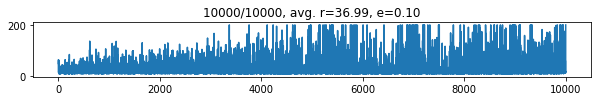

In [11]:
# theta로 부터 theta- 초기화 때 한 번만 복사할 flag
copy = True

r_list = []

for e in range(EPISODES):
    epsilon = f(e)
    s = env.reset()
    s = state_func(s)
    done = False
    
    r_sum = 0.
    
    while not done:
        # 주어진 state로부터 action 구함
        a = tf.squeeze(q.sample_action(s, epsilon))
        
        # (s,a) -> r, s' 구함
        s_prime, r, done, _ = env.step(int(a))
        done_mask = tf.zeros(1,) if done else tf.ones(1,)
        r_sum += r
        
        # action 을 one-hot encoding 해서 transition 에 저장
        _a = np.zeros((env.action_space.n,))
        _a[int(a)] = 1.
        a = tf.cast(_a, dtype=tf.float32)
        r = tf.expand_dims(r,axis=0)
        
        # state -> one-hot encoding 해서 transition 에 저장
        s_prime = state_func(s_prime)
        
        # (s, a, r, s') transition 을 저장해줌
        memory.put((s, a, r, s_prime, done_mask))
        
        # 다음 state s' 가 이제 현재 s가 됨
        s = s_prime.numpy()
        
        
        # 에피소드 끝
        if done: 
            r_list.append(r_sum)
            break
            
        if copy:
            q(memory.sample(1)[0])
            q_target(memory.sample(1)[0])
            q_target.set_weights(q.get_weights())
            copy = False
                        
    # transition 몇 개 이상 모이면 학습
    # 성공 경험이 있을 때 학습
    if memory.size() > 2000 and np.sum(r_list) > 0:
        train(q, q_target, memory)
        
    if e != 0 and e%20 == 0:
        
        # 가끔 behaviour 를 target에 복사해줌
        q_target.set_weights(q.get_weights())
        
    ipd.clear_output(wait=True)
    plt.figure(facecolor='w',figsize=(10,1))
    plt.plot(r_list)
    plt.title(f"{e+1}/{EPISODES}, avg. r={np.sum(r_list[-100:])/100:.2f}, e={epsilon:.2f}")
    plt.show()
        
env.close()